# Summary
This notebook summarises all the analyses and visualisations done to understand various relationships in the internal and external datasets.

### Imports and Pyspark session

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os, sys, ssl
from functools import reduce
import string, re

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import countDistinct, col
import pyspark.sql.functions as F

#import nltk
#from nltk.corpus import stopwords
#from nltk.stem import WordNetLemmatizer

In [2]:
sp = SparkSession.builder.appName("Summary").getOrCreate()

22/10/13 11:14:37 WARN Utils: Your hostname, J-L resolves to a loopback address: 127.0.1.1; using 172.21.176.66 instead (on interface eth0)
22/10/13 11:14:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/13 11:14:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Read all relevant files

In [3]:
# from scripts.utils import read_tables

transactions = sp.read.option("inferSchema", True).parquet("../data/processed/transactions/")
customers = sp.read.option("inferSchema", True).parquet("../data/processed/customers/")
merchants = sp.read.option("inferSchema", True).parquet("../data/processed/merchants/")

cFraud = sp.read.option("inferSchema", True).parquet("../data/curated/customer_fraud/")
mFraud = sp.read.option("inferSchema", True).parquet("../data/curated/merchant_fraud/")

In [4]:
sns.set_style("whitegrid")
sns.set_palette("winter")

### Checking Dollar values by date

In [5]:
amount_per_day = transactions.groupBy("order_datetime").sum("dollar_value").toPandas()
amount_per_day.columns = ["order dates", "transaction amount"]
amount_per_day["order dates"] = pd.to_datetime(amount_per_day["order dates"])
amount_per_day.sort_values(by="order dates", inplace=True)

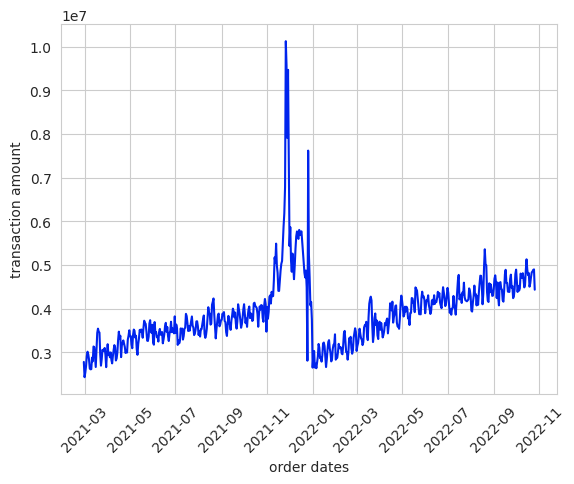

In [6]:
sns.lineplot(x="order dates", y="transaction amount", data=amount_per_day)
plt.xticks(rotation=45)
plt.show()

There is a clear spike around December, which might indicate an association between the major public holidays and purchases.

In [14]:
# Checking date limits
amount_per_day[amount_per_day["order dates"] > "2022-08-28"].count()

order dates           59
transaction amount    59
dtype: int64

We find that there are 59 transactions beyond the given date range. But that is fine as it simply adds to more relevant data.

Let's check the pattern observed in the above graph more closely

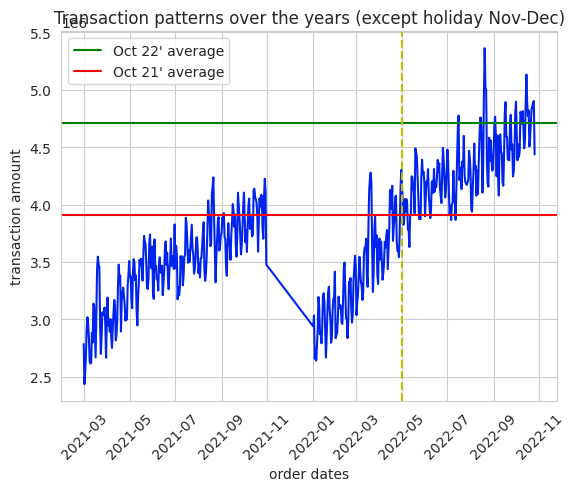

In [7]:
pattern_check = amount_per_day[(amount_per_day["order dates"] < "11-1-2021") | (amount_per_day["order dates"] >"1-1-2022")]

sns.lineplot(x="order dates", y="transaction amount", data=pattern_check)

oct_2011_avg = amount_per_day[(amount_per_day["order dates"] >= "10-1-2021") & (amount_per_day["order dates"] < "11-1-2021")]["transaction amount"].mean()
oct_2022_avg = amount_per_day[(amount_per_day["order dates"] >= "10-1-2022") & (amount_per_day["order dates"] < "11-1-2022")]["transaction amount"].mean()

plt.axhline(oct_2022_avg, color='g', label="Oct 22' average")
plt.axhline(oct_2011_avg, color='r', label="Oct 21' average")

plt.axvline(pd.to_datetime("5-1-2022"), color='y', linestyle="--")

plt.legend()
plt.title("Transaction patterns over the years (except holiday Nov-Dec)")

plt.xticks(rotation=45)
plt.show()

As seen in the graph, over the years of 21 and 22, there have been significant growth and fast paced recovery (considering a COVID effect on real-world like application). It is also important to note that there is a significant pattern in terms of purchasing power of customers. More of a deep dive is required to understand why it is an incresing trend every year rather than an overall increasing/linear trend

## Special analysis of holiday season

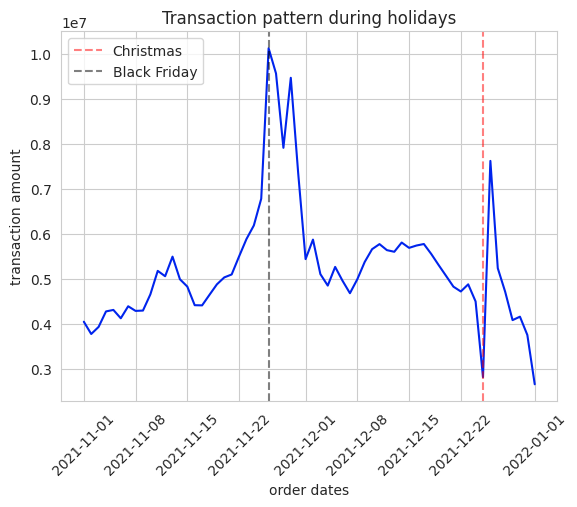

In [8]:
holiday_check = amount_per_day[(amount_per_day["order dates"] >= "11-1-2021") & (amount_per_day["order dates"] <= "1-1-2022")]

sns.lineplot(x="order dates", y="transaction amount", data=holiday_check)

plt.axvline(pd.to_datetime("12-25-2021"), color='r', linestyle="--", label="Christmas", alpha=0.5)
plt.axvline(pd.to_datetime("11-26-2021"), color='black', linestyle="--", label="Black Friday", alpha=0.5)

plt.title("Transaction pattern during holidays")
plt.legend()

plt.xticks(rotation=45)
plt.show()

#### Analysis of average transaction values

In [9]:
avg_per_day = transactions.groupBy("order_datetime").avg("dollar_value").toPandas()
avg_per_day.columns = ["Order dates", "Average value"]
avg_per_day["Order dates"] = pd.to_datetime(avg_per_day["Order dates"])
avg_per_day.sort_values(by="Order dates", inplace=True)

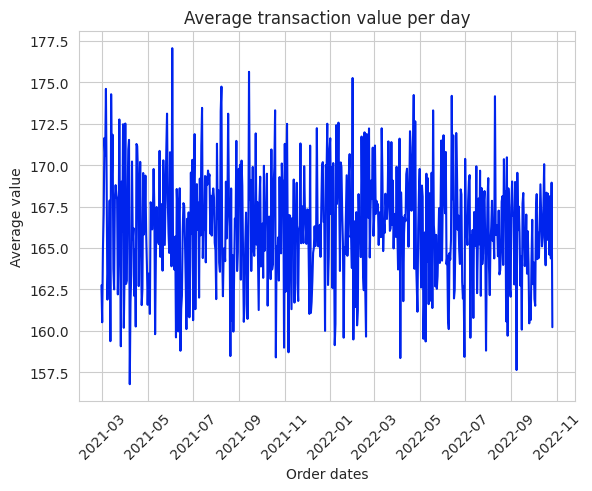

In [10]:
sns.lineplot(x="Order dates", y="Average value", data=avg_per_day)

plt.title("Average transaction value per day")

plt.xticks(rotation=45)
plt.show()

As seen above, this is a fairly linear graph showing that the people still purchased items worth the same amount as they would during non-holiday periods

## Day of week

In [11]:
day_of_week = amount_per_day.groupby(amount_per_day["order dates"].dt.day_name()).mean()

In [12]:
day_of_week.index

Index(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'],
      dtype='object', name='order dates')

<AxesSubplot:xlabel='order dates', ylabel='transaction amount'>

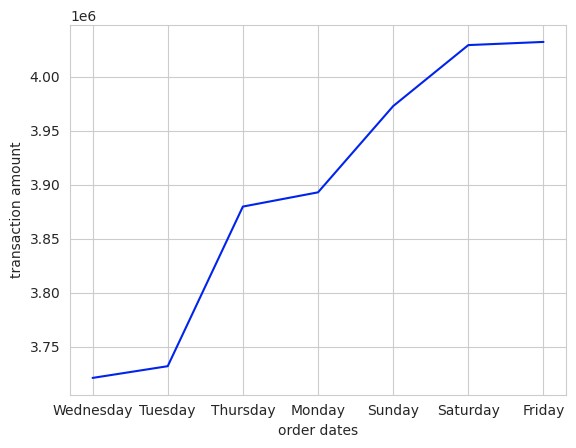

In [13]:
sorted_day_of_week = day_of_week.sort_values(by="transaction amount")
sns.lineplot(data=sorted_day_of_week, x=sorted_day_of_week.index, y="transaction amount")

Huge number of transactions seen over Fri-Sun. Monday and Thursday being almost equal but subpar to the weekend. Tuesday and Wednesday being the least of all

## Public Holidays

In [14]:
from pyspark.sql.types import DateType

data = ['2021-03-08','2021-04-02','2021-04-03','2021-04-04','2021-04-05','2021-04-25','2021-06-14','2021-09-24','2021-11-02','2021-12-25','2021-12-26','2021-12-27','2021-12-28','2022-01-01','2022-01-03','2022-01-26','2022-03-14','2022-04-15','2022-04-16','2022-04-17','2022-04-18','2022-04-25','2022-06-13','2022-09-22','2022-09-23']
dates = pd.date_range(start='2021-02-01', end='2022-10-31')

list1 = []
for date in dates:
    _date = date.strftime('%Y-%m-%d')
    if _date in data:
        # print(_date)
        list1.append((_date, 1))
    else:
        list1.append((_date, 0))
holiday_data = sp.createDataFrame(pd.DataFrame(list1, columns =['Date', 'holiday?']))
holiday_data = holiday_data.withColumn("Date",col("Date").cast(DateType()))

In [15]:
holiday_data.show(3)

+----------+--------+
|      Date|holiday?|
+----------+--------+
|2021-02-01|       0|
|2021-02-02|       0|
|2021-02-03|       0|
+----------+--------+
only showing top 3 rows



In [16]:
holiday_fraud = holiday_data.join(cFraud, holiday_data.Date == cFraud.order_datetime).drop('order_datetime', 'user_id').toPandas()
holiday_fraud.head(5)

,Date,holiday?,fraud_probability
0,2021-02-28,0,10.815052
1,2021-02-28,0,9.689173
2,2021-02-28,0,9.802295
3,2021-02-28,0,10.447137
4,2021-02-28,0,9.131703


In [17]:
holiday_fraud['holiday?'].value_counts()

0    24569
1     1464
Name: holiday?, dtype: int64

In [18]:
normal_days = holiday_fraud.loc[holiday_fraud['holiday?']==0]
normal_days_sample = normal_days.sample(n=1665, random_state=111)

In [20]:
holiday_fraud_unbiased = pd.concat([normal_days_sample, holiday_fraud.loc[holiday_fraud['holiday?']==1]])

In [21]:
holiday_fraud_unbiased['holiday?'].value_counts()

0    1665
1    1464
Name: holiday?, dtype: int64

In [22]:
holiday_fraud['holiday?'].corr(holiday_fraud['fraud_probability'])

0.005267618067578969

The Pearson's correlation coefficient is also very low, further strengthening the result that these two aren't really related.

## Merhchant Tags

In [ ]:
# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

# nltk.download()

# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# This is used to for NLP of the description
def text_process(text):
    stemmer = WordNetLemmatizer()
    # Remove all punctuation and numbers 
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join([i for i in nopunc if not i.isdigit()])
    # Remove all stopwords
    nopunc =  [word.lower() for word in nopunc.split() if word not in stopwords.words('english')]
    # lemmatize and output
    return ' '.join([stemmer.lemmatize(word) for word in nopunc])

In [ ]:
merchants_pd = merchants.toPandas()

def tag_extract(tag_string): 
    # first need to preprocess
    string =  re.sub('\[','(', tag_string.lower())
    string = re.sub('\]',')', string)
    # break the string into sections
    string_cut = string.split('),')
    new_string = []
    
    # first extract the description and pre process
    descr = str(string_cut[0].strip('(('))
    new_string.append(text_process(descr))
    # second extract the band
    new_string.append(str(re.search(r'[a-z]',string_cut[1]).group()))
    # finally the take rate
    new_string.append(float(re.search(r'[0-9]+\.[0-9]+',string_cut[2]).group()))
    return(new_string)
################
# now we can run the algorithm
tags = merchants_pd['tags']
processed_tags = []
for i in tags:
    processed_tags.append(tag_extract(i))

In [ ]:
merchant_tbl = pd.DataFrame(processed_tags, columns=('Description', 'Earnings_Class', 'BNPL_Fee'))

merchant_tbl = pd.concat([merchants_pd, merchant_tbl], axis=1)
# drop the tags column 
merchant_tbl.drop(columns=['tags'], inplace=True)

In [ ]:
set(merchant_tbl['Description'])

{'antique shop sale repair restoration service',
 'art dealer gallery',
 'artist supply craft shop',
 'bicycle shop sale service',
 'book periodical newspaper',
 'cable satellite pay television radio service',
 'computer computer peripheral equipment software',
 'computer programming data processing integrated system design service',
 'digital good book movie music',
 'equipment tool furniture appliance rent al leasing',
 'florist supply nursery stock flower',
 'furniture home furnishing equipment shop manufacturer except appliance',
 'gift card novelty souvenir shop',
 'health beauty spa',
 'hobby toy game shop',
 'jewelry watch clock silverware shop',
 'lawn garden supply outlet including nursery',
 'motor vehicle supply new part',
 'music shop musical instrument piano sheet music',
 'optician optical good eyeglass',
 'shoe shop',
 'stationery office supply printing writing paper',
 'telecom',
 'tent awning shop',
 'watch clock jewelry repair shop'}

In [ ]:
merchant_tbl.to_csv("../data/curated/merchants_tbl_processed.csv")

In [ ]:
merchant_tbl = sp.read.option("header", True).csv("../data/curated/merchants_tbl_processed.csv").drop('_c0', 'name')
merchant_tbl.show(3)

+------------+--------------------+--------------+--------+
|merchant_abn|         Description|Earnings_Class|BNPL_Fee|
+------------+--------------------+--------------+--------+
| 10023283211|furniture home fu...|             e|    0.18|
| 10142254217|cable satellite p...|             b|    4.22|
| 10165489824|jewelry watch clo...|             b|     4.4|
+------------+--------------------+--------------+--------+
only showing top 3 rows



## Earnings Class

In [ ]:
merch_tran = transactions.join(merchant_tbl, on="merchant_abn")

check_class = merch_tran.groupBy("merchant_abn").sum("dollar_value").join(merchant_tbl, on="merchant_abn")
check_class.show(4)

+------------+-----------------+--------------------+--------------+--------+
|merchant_abn|sum(dollar_value)|         Description|Earnings_Class|BNPL_Fee|
+------------+-----------------+--------------------+--------------+--------+
| 38700038932|9546185.360697314|    tent awning shop|             a|    6.31|
| 83412691377|498536.5816973136|watch clock jewel...|             c|    2.94|
| 15613631617| 543030.531332826|motor vehicle sup...|             e|    0.35|
| 19839532017|         113982.0|cable satellite p...|             b|    4.94|
+------------+-----------------+--------------------+--------------+--------+
only showing top 4 rows



In [ ]:
check_class.groupBy("Earnings_Class").avg("sum(dollar_value)").show()
plot_class = check_class.toPandas()

+--------------+----------------------+
|Earnings_Class|avg(sum(dollar_value))|
+--------------+----------------------+
|             e|     466409.1137064723|
|             d|     380160.4808673627|
|             c|     492228.4833728333|
|             b|     572100.8022827655|
|             a|     542033.4187956803|
+--------------+----------------------+



<AxesSubplot:xlabel='BNPL_Fee', ylabel='take away revenue'>

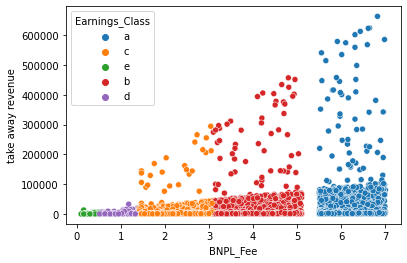

In [ ]:
plot_class["BNPL_Fee"] = pd.to_numeric(plot_class["BNPL_Fee"])
plot_class["take away revenue"] = plot_class["BNPL_Fee"] * plot_class["sum(dollar_value)"] / 100

sns.scatterplot(x="BNPL_Fee", y="take away revenue", hue="Earnings_Class", data=plot_class)

## Transaction Distributions

In [ ]:
pie_chart = transactions.groupBy("user_id").count().withColumnRenamed("count", "Num Trans").groupBy("Num Trans").count().toPandas()
pie_chart.sort_values(by="Num Trans", inplace=True)
pie_chart.count()

Num Trans    53
count        53
dtype: int64

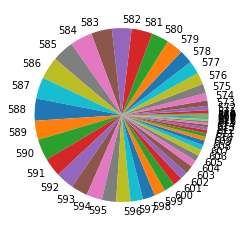

In [ ]:
plt.pie(x=pie_chart["count"], labels=pie_chart["Num Trans"])
plt.show()

<AxesSubplot:xlabel='Num Trans', ylabel='count'>

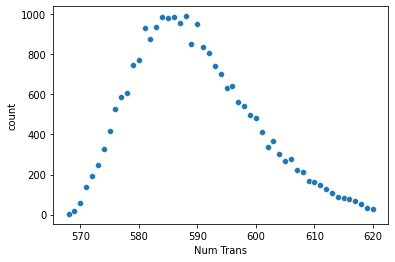

In [ ]:
sns.scatterplot(y="count", x="Num Trans", data=pie_chart)

## Constant purchases with a dollar value of 157.0

In [24]:
constant = transactions.filter(transactions.dollar_value == 157)

merchant_constant_pd = constant.groupBy("merchant_abn").count()
datetime_constant_pd = constant.groupBy("order_datetime").count().toPandas()
user_id_constant_pd = constant.groupBy("user_id").count().toPandas()

In [25]:
constant.count()

41014

In [ ]:
datetime_constant_pd["order_datetime"] = pd.to_datetime(datetime_constant_pd["order_datetime"])

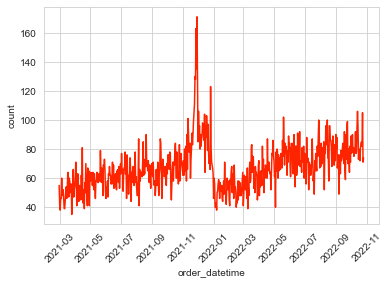

In [ ]:
sns.lineplot(x="order_datetime", y="count", data=datetime_constant_pd.sort_values(by="order_datetime"))

plt.xticks(rotation=45)
plt.show()

In [ ]:
merch_constant = merchant_constant_pd.join(merchant_tbl, ['merchant_abn'])

In [ ]:
merch_constant.select('Description').distinct().collect()

[Row(Description='cable satellite pay television radio service')]

All of these transactions belong to a single description, namely "cable satellite pay television radio service", which could be some kind of a periodic subscription service. Since this does not raise any concerns regarding the legitimacy of these transactions, we will include them in further analysis and modelling.

## Outlier detection for dollar value

In [ ]:
full_dataset = transactions.join(customers, ['user_id'])
merchants_tbl = merchant_tbl.withColumnRenamed('name','company_name')
full_dataset = full_dataset.join(merchants_tbl, ['merchant_abn'])

In [29]:
full_dataset = transactions.join(customers.select("state", "postcode", "gender", "user_id"), on="user_id").join(merchants.select("merchant_abn", "Earnings_Class", "BNPL_Fee", "tags"), on="merchant_abn")
full_dataset.show(1)

+------------+-------+--------+------------+--------------+-----------+-----------------+-------+----------+-----+---------+-----+--------+------+--------------+--------+----+
|merchant_abn|user_id|order_id|dollar_value|order_datetime|Natural_var|Potential_Outlier|holiday|dayofmonth|month|dayofweek|state|postcode|gender|Earnings_Class|BNPL_Fee|tags|
+------------+-------+--------+------------+--------------+-----------+-----------------+-------+----------+-----+---------+-----+--------+------+--------------+--------+----+
| 60956456424|      3|       3|      136.68|    2021-08-20|          0|                0|      0|        20|    8|        6|   NT|     862|Female|             b|    4.69|   5|
+------------+-------+--------+------------+--------------+-----------+-----------------+-------+----------+-----+---------+-----+--------+------+--------------+--------+----+
only showing top 1 row



In [30]:
full_dataset.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- user_id: long (nullable = true)
 |-- order_id: long (nullable = true)
 |-- dollar_value: float (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- Natural_var: integer (nullable = true)
 |-- Potential_Outlier: integer (nullable = true)
 |-- holiday: long (nullable = true)
 |-- dayofmonth: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: long (nullable = true)
 |-- gender: string (nullable = true)
 |-- Earnings_Class: string (nullable = true)
 |-- BNPL_Fee: double (nullable = true)
 |-- tags: integer (nullable = true)



In [ ]:
full_dataset.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- user_id: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Earnings_Class: string (nullable = true)
 |-- BNPL_Fee: string (nullable = true)



In [31]:
# add a day of the week, weekly & monthly attribute
full_dataset = full_dataset.withColumn('Day', F.dayofweek('order_datetime'))
full_dataset = full_dataset.withColumn('Month', F.month('order_datetime'))

# round each dollar value to the nearest cent (not 5 cents, as there exists unusual pricing in the real world)
full_dataset = full_dataset.withColumn("dollar_value", F.round(F.col("dollar_value"), 2))

# now we can also add the bnpl revenue from a transaction 
full_dataset = full_dataset.withColumn('BNPL_Revenue', 
                        (F.col('dollar_value') * 0.01 * F.col('BNPL_Fee')))

### Outlier detection algorithm
This will be inplemented by creating an attribute called 'potential outlier'. which marks dollar values of transactios that fall out of a companies specific SIQR as True, and False otherwise. Furthermore, it marks all transactions that belong to a company, which has no variance in the dollar value of respective transactios. This is due to it being unrealistic/dodgy.

In [32]:
# use the SIQR range
# see https://towardsdatascience.com/outlier-detection-part-2-6839f6199768
Fst_percentile = F.expr('percentile_approx(dollar_value, 0.25)')
Trd_percentile = F.expr('percentile_approx(dollar_value, 0.75)')
Second_percentile = F.expr('percentile_approx(dollar_value, 0.5)')
quartile_dataset = full_dataset.groupBy('merchant_abn').agg(Fst_percentile.alias('1_val'), Trd_percentile.alias('3_val'), Second_percentile.alias('2_val'), F.count('dollar_value').alias('Count'))
quartile_dataset = quartile_dataset.withColumn('SIQR_Lower', F.col('2_val') - F.col('1_val'))
quartile_dataset = quartile_dataset.withColumn('SIQR_Upper', F.col('3_val') - F.col('2_val'))

# Now calculate the limits
quartile_dataset = quartile_dataset.withColumn('Upper_limit', F.col('3_val') + 3 * F.col('SIQR_Upper'))
quartile_dataset = quartile_dataset.withColumn('Lower_limit', F.col('1_val') - 3 * F.col('SIQR_Lower'))

# after noticing that some merchants only have one transaction value (i.e one dollar_value amount for all transactios)
# decided to removed due to unrealisic distributed data 
quartile_dataset = quartile_dataset.withColumn('Natural_var', F.when((F.col('Upper_limit') == F.col('Lower_limit')) & (F.col('Count') > 10), True).otherwise(False))
quartile_dataset = quartile_dataset.select('merchant_abn', 'Upper_limit', 'Lower_limit', 'Natural_var')

In [33]:
# Now all we need to do is join this data to each transaction, then can select the transactios which are (not) within the limits
full_quantile = full_dataset.select('merchant_abn', 'order_id', 'user_id', 'dollar_value').join(quartile_dataset, on= ['merchant_abn'])

In [34]:
# finally identify the outliers which fall out of distribution or apart of a dodgy business
full_quantile = full_quantile.withColumn('Potential_Outlier', F.when((full_quantile.dollar_value <= F.col('Upper_limit')) & (full_quantile.dollar_value >= F.col('Lower_limit')) & (F.col('Natural_var') == False), False)
                                              .otherwise(True))

In [35]:
full_quantile.where(F.col('Potential_Outlier') == True).count()

339772

In [36]:
full_quantile.show(1)

+------------+--------+-------+------------+-----------+-----------+-----------+-----------------+
|merchant_abn|order_id|user_id|dollar_value|Upper_limit|Lower_limit|Natural_var|Potential_Outlier|
+------------+--------+-------+------------+-----------+-----------+-----------+-----------------+
| 10023283211|   93436|  11810|       67.14|  615.24005| -104.24001|      false|            false|
+------------+--------+-------+------------+-----------+-----------+-----------+-----------------+
only showing top 1 row



### Description analysis

In [ ]:
full_dataset.createOrReplaceTempView('data')
cFraud.createOrReplaceTempView('fraud')
dataset = sp.sql("""
select Description, avg(fraud_probability) as description_avg from data, fraud where (fraud.user_id == data.user_id) AND (fraud.order_datetime == data.order_datetime)
group by Description""")
dataset_pd = dataset.toPandas()

In [ ]:
tag_word = np.array([tag.split()[0] for tag in dataset_pd.Description])
df1 = pd.DataFrame(tag_word, dataset_pd.description_avg)

<AxesSubplot:xlabel='0', ylabel='description_avg'>

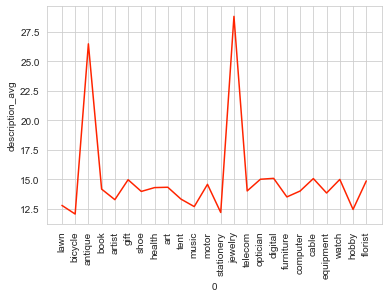

In [ ]:
plt.xticks(rotation=90)
sns.lineplot(x=df1[0], y=df1.index)


We can see from the above graph that jewellery companies have a higher average fraud probability followed by antique. Both of them are sectors with high dollar value. Fraud in such companies have been found in past literature (), and our analysis verifies the same.

In [ ]:
dataset.createOrReplaceTempView('fraud')
dataset = sp.sql("""
select * from data, fraud where fraud.Description == data.Description""")

In [ ]:
Administrative_Support_Services= ["equipment tool furniture appliance rent al leasing", "florist supply nursery stock flower", "lawn garden supply outlet including nursery"]

Personal_Services= ["shoe shop", "gift card novelty souvenir shop", "antique shop sale repair restoration service", "watch clock jewellery repair shop", "jewellery watch clock silverware shop",  "motor vehicle supply new part", "furniture home furnishing equipment shop manufa...", "tent awning shop", "optician optical good eyeglass"]

Arts_Recreation_Services = ["digital good book movie music", "music shop musical instrument piano sheet music", "health beauty spa", "bicycle shop sale service", "art dealer gallery", "hobby toy game shop", "stationery office supply printing writing paper"]

Information_Media_Telecommunications = ["telecom", "computer programming data processing integrated...", "book periodical newspaper", "artist supply craft shop", "computer computer peripheral equipment software", "cable satellite pay television radio service"]

desc = []
tags = []
for ele in Administrative_Support_Services:
    desc.append("Administrative_Support_Services")
tags += Administrative_Support_Services
for ele in Personal_Services:
    desc.append("Personal_Services")
tags += Personal_Services
for ele in Arts_Recreation_Services:
    desc.append("Arts_Recreation_Services")
tags += Arts_Recreation_Services
for ele in Information_Media_Telecommunications:
    desc.append("Information_Media_Telecommunications")
tags += Information_Media_Telecommunications

to_df = {
    "sector" :  desc,
    "Description" : tags
}
sectors = sp.createDataFrame(pd.DataFrame(to_df))
dataset_sect = dataset.join(sectors, ['Description'])
dataset_sect.createOrReplaceTempView('data')
dataset_sect_final = dataset_sect.join(sp.sql("""select sector, avg(description_avg) as sector_avg from data group by sector"""), ['sector'])

In [ ]:
sect_avg = sp.sql("""select sector, avg(description_avg) as sector_avg from data group by sector""")

22/10/06 04:09:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/06 04:09:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/06 04:09:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/06 04:09:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/06 04:09:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/06 04:09:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/06 04:09:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/06 04:09:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/06 04:09:10 WARN RowBasedKeyValueBatch: Calling spill() on

<AxesSubplot:xlabel='sector', ylabel='sector_avg'>

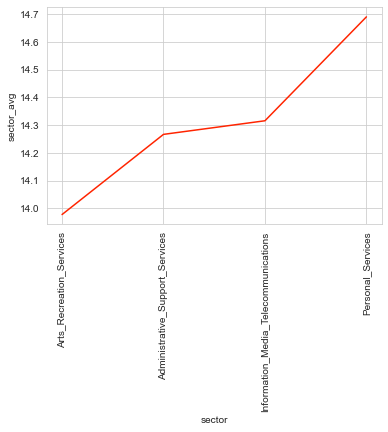

In [ ]:
sect_avg = sect_avg.toPandas()

plt.xticks(rotation=90)
sns.lineplot(x=sect_avg.sector, y=sect_avg.sector_avg)

Our analysis is futher supported by the graph above which shows personal services like antiques, watch and jewellery have higher chances of being fraud.

In [ ]:
sec_grouped = dataset_sect_final.groupBy("sector").sum("dollar_value")

In [ ]:
dataset_sect_final.count()

11561600

### Postcode Transaction analysis

In [ ]:
import sys, os
sys.path.append(os.path.join(os.path.dirname(sys.path[0]),'scripts'))
#print(sys.path)
import utils as u

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import countDistinct, col
import pyspark.sql.functions as F
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
sp = (
    SparkSession.builder.appName("merchants")
    .config("spark.sql.session.timeZone", "+11")
    .config("spark.driver.memory", "10g")
    .config("spark.executor.memory", "10g")
    .config('spark.sql.parquet.cacheMetadata', 'True')
    .getOrCreate()
)
sp

In [ ]:
full_data = sp.read.parquet("../data/full_dataset/")
fraud_probabilities = sp.read.parquet('../models/random_forest_output_full/')
fraud_probabilities = fraud_probabilities.select('merchant_abn', 'user_id', 'order_datetime', 'prediction')

In [ ]:
full_data.printSchema()


root
 |-- order_id: string (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- user_id: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- consumer_id: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: string (nullable = true)
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- sa3name: string (nullable = true)
 |-- sa4name: string (nullable = true)
 |-- electoraterating: string (nullable = true)
 |-- SA3_NAME_2016: string (nullable = true)
 |-- electorate: string (nullable = true)
 |-- Number of individuals lodging an income tax return: long (nullable = true)
 |-- Average taxable income or loss: long (nullable = true)
 |-- Median taxable income or loss: long (nullable = true)
 |-- Proportion with salary or wages: long (nullable = true)
 |-- Count salary or wages: long (nullable = true)
 |-- Average salary or wages: l

# Company Basic Selling Performance

- Total revenue
- Customer base and distribution
- Growth
- Industry

In [ ]:
#see the distribution of total revenue
total_revenue = full_data.groupBy(col("merchant_abn")).sum("dollar_value")
total_revenue = total_revenue.withColumnRenamed("sum(dollar_value)", "total_revenue")
total_revenue.count()
total_revenue.printSchema()
total_revenue_df = total_revenue.toPandas()

root
 |-- merchant_abn: long (nullable = true)
 |-- total_revenue: double (nullable = true)



In [ ]:
#total num of transactions 
total_transactions = full_data.groupBy(col("merchant_abn")).count()
total_transactions = total_transactions.withColumnRenamed("count", "total_num_transaction")
total_transactions_df = total_transactions.toPandas()

In [ ]:
revenue_numTransac = total_transactions_df.set_index("merchant_abn").join(total_revenue_df.set_index("merchant_abn"))
revenue_numTransac.head()

,total_num_transaction,total_revenue
merchant_abn,,
83412691377,10988,385167.80
38700038932,5511,7346938.26
15613631617,1429,433051.58
73256306726,4117,1204237.54
73841664453,734,63980.31


<AxesSubplot: xlabel='total_num_transaction', ylabel='total_revenue'>

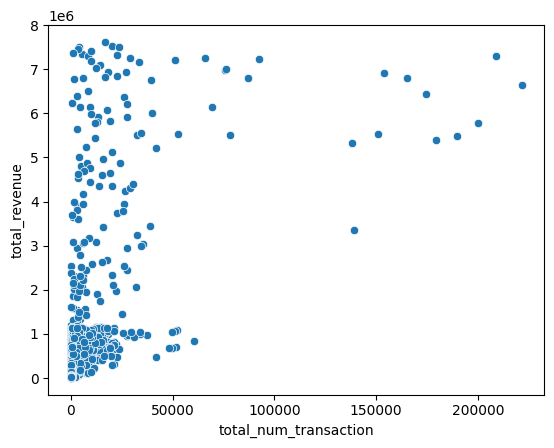

In [ ]:
sns.scatterplot(x = revenue_numTransac["total_num_transaction"], y = revenue_numTransac["total_revenue"])

<AxesSubplot: xlabel='avg_dollar_value', ylabel='total_num_transaction'>

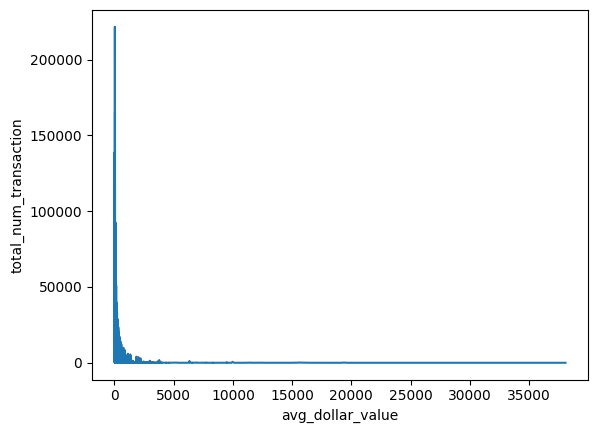

In [ ]:
revenue_numTransac["avg_dollar_value"] = revenue_numTransac["total_revenue"]/revenue_numTransac["total_num_transaction"]
sns.lineplot(x = revenue_numTransac["avg_dollar_value"], y = revenue_numTransac["total_num_transaction"])

In [ ]:
#see the distribution of the high revenue companies
money_makers = total_revenue.filter(col("total_revenue") > 1000000)
money_makers = money_makers.distinct()
print("number of very high revenue: ", money_makers.count())
print("the percentage: ", money_makers.count()/total_revenue.count())
money_makers = money_makers.toPandas()

number of very high revenue:  322


the percentage:  0.0801792828685259


In [ ]:
descriptions = full_data.select("merchant_abn", "Description", "Earnings_Class","BNPL_Revenue")
descriptions = descriptions.drop_duplicates(["merchant_abn", "Description"])
descriptions.count()
descriptions = descriptions.toPandas()

In [ ]:
#focus on the high revnue ones
money_makers_info = money_makers.set_index("merchant_abn").join(descriptions.set_index("merchant_abn"))

total_revenue     322
Description       322
Earnings_Class    322
BNPL_Revenue      322
dtype: int64

<AxesSubplot: ylabel='total_revenue'>

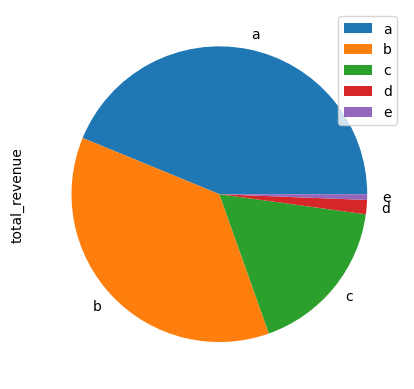

In [ ]:
by_Eclass_count = money_makers_info.groupby("Earnings_Class").count()
by_Eclass_count.plot.pie(y = "total_revenue")

In [ ]:
merchants = sp.read.parquet("../data/tables/processed/merchants/")
merchants.printSchema()

root
 |-- merchant_abn: long (nullable = true)
 |-- name: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- avg_monthly_inc: float (nullable = true)
 |-- monthly_entropy: float (nullable = true)
 |-- postcode_entropy: float (nullable = true)
 |-- revenue: double (nullable = true)



In [ ]:
money_makers = total_revenue.filter(col("total_revenue") > 1000000)
money_makers = money_makers.distinct()
merchants = sp.read.parquet("../data/tables/processed/merchants/")
please_let_me = merchants.join(money_makers)


# Customer base analysis


In [ ]:
total_unique = full_data.groupBy("merchant_abn").agg(F.countDistinct(F.col("consumer_id")))
total_unique.show()
#sns.histplot(total_unique.toPandas()[])

+------------+------------------+
|merchant_abn|count(consumer_id)|
+------------+------------------+
| 73256306726|              3144|
| 15613631617|              1150|
| 38700038932|              4140|
| 83412691377|              7621|
| 48214071373|               321|
| 73841664453|               578|
| 52763133264|                88|
| 35344855546|               952|
| 41956465747|               180|
| 19839532017|               467|
| 12516851436|               134|
| 96946925998|                85|
| 34440496342|               137|
| 37935728745|                11|
| 92202115241|                75|
| 38986645707|                23|
| 60654402457|               115|
| 78916025936|                40|
| 57798993346|                 9|
| 59128133246|              3779|
+------------+------------------+
only showing top 20 rows



<AxesSubplot: xlabel='unqie_customers', ylabel='total_num_transaction'>

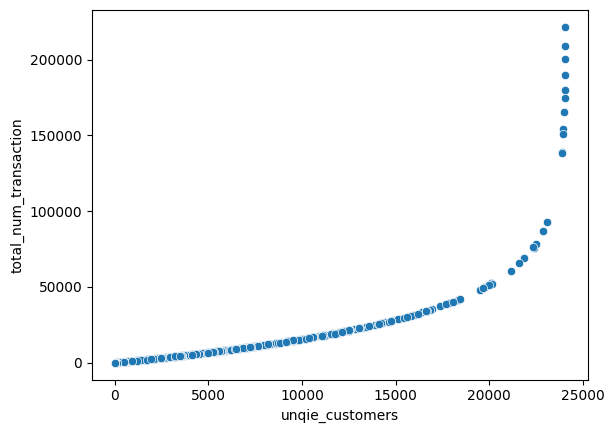

In [ ]:
customer_joined = total_unique.toPandas().set_index("merchant_abn").join(revenue_numTransac)
customer_joined["unqie_customers"] = customer_joined["count(consumer_id)"]
sns.scatterplot(x = customer_joined["unqie_customers"], y = customer_joined["total_num_transaction"])

# MODEL

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

from pyspark.ml import Pipeline
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import MultilayerPerceptronClassifier, RandomForestClassifier
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator

In [ ]:
sp = (
    SparkSession.builder.appName("Model")
    .config("spark.sql.session.timeZone", "+11")
    .config("spark.driver.memory", "10g")
    .config("spark.executor.memory", "10g")
    .config('spark.sql.parquet.cacheMetadata', 'True')
    .getOrCreate()
)
sp

In [ ]:
transactions = sp.read.option("inferSchema", True).parquet("../data/processed/transactions")
merchants = sp.read.option("inferSchema", True).parquet("../data/processed/merchants")
customers = sp.read.option("inferSchema", True).parquet("../data/processed/customers")

In [ ]:
transactions.show(1)
merchants.show(1)
customers.head(1)

+--------+-------+------------+------------+--------------+-----------+-----------------+-------+----------+-----+---------+
|order_id|user_id|merchant_abn|dollar_value|order_datetime|Natural_var|Potential_Outlier|holiday|dayofmonth|month|dayofweek|
+--------+-------+------------+------------+--------------+-----------+-----------------+-------+----------+-----+---------+
|       3|      3| 60956456424|      136.68|    2021-08-20|          0|                0|      0|        20|    8|        6|
+--------+-------+------------+------------+--------------+-----------+-----------------+-------+----------+-----+---------+
only showing top 1 row

+------------+-------------+--------------+--------+----+---------------+---------------+----------------+-----------------+
|merchant_abn|         name|Earnings_Class|BNPL_Fee|tags|avg_monthly_inc|monthly_entropy|postcode_entropy|          revenue|
+------------+-------------+--------------+--------+----+---------------+---------------+------------

[Row(state='ACT', postcode=200, gender='Female', user_id=71674, Number of individuals lodging an income tax return=5524, Average taxable income or loss=66722, Median taxable income or loss=52958, Proportion with salary or wages=1, Count salary or wages=5009, Average salary or wages=64930, Median salary or wages=55579, Proportion with net rent=1, Count net rent=762, Average net rent=-4289, Median net rent=-2448, Average total income or loss=68991, Median total income or loss=54988, Average total deductions=2244, Median total deductions=872, Proportion with total business income=1, Count total business income=382, Average total business income=56170, Median total business income=18742, Proportion with total business expenses=1, Count total business expenses=343, Average total business expenses=42645, Median total business expenses=8664, Proportion with net tax=1, Count net tax=4586, Average net tax=18805, Median net tax=11482, Count super total accounts balance=7620, Average super total 

### PROCESSING CUSTOMER FRAUD DATA

In [ ]:
c_fraud = sp.read.option("inferSchema", True).parquet("../data/curated/customer_fraud")
c_fraud = c_fraud.withColumn("order_datetime", col("order_datetime").cast(DateType()))
c_fraud.show(2)

+-------+--------------+-----------------+
|user_id|order_datetime|fraud_probability|
+-------+--------------+-----------------+
|   6228|    2021-12-19|         97.62981|
|  21419|    2021-12-10|         99.24738|
+-------+--------------+-----------------+
only showing top 2 rows



In [ ]:
c_fraud_full = transactions.join(c_fraud, on=["user_id", "order_datetime"])
c_fraud_full.show(2)

+-------+--------------+--------+------------+------------+-----------+-----------------+-------+----------+-----+---------+-----------------+
|user_id|order_datetime|order_id|merchant_abn|dollar_value|Natural_var|Potential_Outlier|holiday|dayofmonth|month|dayofweek|fraud_probability|
+-------+--------------+--------+------------+------------+-----------+-----------------+-------+----------+-----+---------+-----------------+
|    448|    2021-08-20|    1005| 94380689142|     6263.03|          0|                0|      0|        20|    8|        6|        14.681704|
|   3116|    2021-08-20|    6989| 22248828825|     3958.86|          0|                0|      0|        20|    8|        6|         8.809071|
+-------+--------------+--------+------------+------------+-----------+-----------------+-------+----------+-----+---------+-----------------+
only showing top 2 rows



In [ ]:
c_fraud_full.count()

80560

In [ ]:
X = c_fraud_full.join(merchants, on="merchant_abn").join(customers, on="user_id")
X.head(1)

22/10/08 17:06:23 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


[Row(user_id=448, merchant_abn=94380689142, order_datetime=datetime.date(2021, 8, 20), order_id=1005, dollar_value=6263.02978515625, Natural_var=0, Potential_Outlier=0, holiday=0, dayofmonth=20, month=8, dayofweek=6, fraud_probability=14.681703567504883, name='Aliquet Ltd', Earnings_Class='b', BNPL_Fee=3.77, tags=12, avg_monthly_inc=0.0, monthly_entropy=2.710181474685669, postcode_entropy=4.060055732727051, revenue=241562.580078125, state='WA', postcode=6170, gender='Female', Number of individuals lodging an income tax return=4994, Average taxable income or loss=56564, Median taxable income or loss=44772, Proportion with salary or wages=1, Count salary or wages=3916, Average salary or wages=57393, Median salary or wages=49510, Proportion with net rent=1, Count net rent=690, Average net rent=863, Median net rent=255, Average total income or loss=59730, Median total income or loss=47123, Average total deductions=2865, Median total deductions=598, Proportion with total business income=1, 

### Dropping Columns

In [ ]:
X = X.drop("user_id", "merchant_abn", "order_datetime", "order_id", "name", "postcode", "holiday")
X.printSchema()

#### Categorization

- holiday
- dayofmonth
- dayofweek
- month
- tags
- state
- gender
- postcode

In [ ]:
def category_processing(data: DataFrame, outcome: str):
    categories = [
        "dayofmonth",
        "dayofweek",
        "month",
        "tags",
        "state",
        "gender",
        "Earnings_Class"
    ]

    # Pipeline
    indexers = [StringIndexer(inputCol=c, outputCol=c+"_index") for c in categories]
    encoders = [OneHotEncoder(inputCol=c+"_index", outputCol=c+"_encoded") for c in categories]
    transformer = Pipeline(stages=indexers + encoders).fit(data)
    transformed = transformer.transform(data)

    for c in categories:
        transformed = transformed.drop(c).drop(c+"_index")
    return transformer, transformed

In [ ]:
cat_transformer, category_processed = category_processing(X, "outcome")
category_processed.head(1)

[Row(user_id=448, merchant_abn=94380689142, order_datetime=datetime.date(2021, 8, 20), order_id=1005, dollar_value=6263.02978515625, Natural_var=0, Potential_Outlier=0, holiday=0, fraud_probability=14.681703567504883, name='Aliquet Ltd', BNPL_Fee=3.77, avg_monthly_inc=0.0, monthly_entropy=2.710181474685669, postcode_entropy=4.060055732727051, revenue=241562.580078125, postcode=6170, Number of individuals lodging an income tax return=4994, Average taxable income or loss=56564, Median taxable income or loss=44772, Proportion with salary or wages=1, Count salary or wages=3916, Average salary or wages=57393, Median salary or wages=49510, Proportion with net rent=1, Count net rent=690, Average net rent=863, Median net rent=255, Average total income or loss=59730, Median total income or loss=47123, Average total deductions=2865, Median total deductions=598, Proportion with total business income=1, Count total business income=457, Average total business income=93034, Median total business inc

## TRAIN TEST SPLIT

In [ ]:
from pyspark.ml.feature import Bucketizer

buckets = Bucketizer(splits=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], inputCol="fraud_probability", outputCol="fraud_buckets")
X_bucks = buckets.transform(category_processed).drop("fraud_probability")

X_bucks.head(1)

[Row(user_id=448, merchant_abn=94380689142, order_datetime=datetime.date(2021, 8, 20), order_id=1005, dollar_value=6263.02978515625, Natural_var=0, Potential_Outlier=0, holiday=0, name='Aliquet Ltd', BNPL_Fee=3.77, avg_monthly_inc=0.0, monthly_entropy=2.710181474685669, postcode_entropy=4.060055732727051, revenue=241562.580078125, postcode=6170, Number of individuals lodging an income tax return=4994, Average taxable income or loss=56564, Median taxable income or loss=44772, Proportion with salary or wages=1, Count salary or wages=3916, Average salary or wages=57393, Median salary or wages=49510, Proportion with net rent=1, Count net rent=690, Average net rent=863, Median net rent=255, Average total income or loss=59730, Median total income or loss=47123, Average total deductions=2865, Median total deductions=598, Proportion with total business income=1, Count total business income=457, Average total business income=93034, Median total business income=32873, Proportion with total busin

In [ ]:
X_bucks.groupBy("fraud_buckets").count().orderBy("fraud_buckets").show()

+-------------+-----+
|fraud_buckets|count|
+-------------+-----+
|          0.0|22923|
|          1.0|38611|
|          2.0| 6113|
|          3.0| 1934|
|          4.0|  990|
|          5.0|  576|
|          6.0|  360|
|          7.0|  193|
|          8.0|  102|
|          9.0|   11|
+-------------+-----+



In [ ]:
from functools import reduce

In [ ]:

fractions = [0, 0, 0, 2, 4, 7, 15, 20, 35, 250]

X_adjusted = reduce(
    DataFrame.unionAll,
    [X_bucks.filter(X_bucks.fraud_buckets == float(x)).sample(withReplacement=True, fraction=float(fractions[x]), seed=69) for x in range(3, 10)]
)
X_adjusted = reduce(
    DataFrame.unionAll,
    [X_adjusted] + [X_bucks.filter(X_bucks.fraud_buckets == float(x)) for x in range(0, 3)]
)

X_adjusted.count()

95171

In [ ]:
X_adjusted.groupBy("fraud_buckets").count().orderBy("fraud_buckets").show()

+-------------+-----+
|fraud_buckets|count|
+-------------+-----+
|          0.0|22923|
|          1.0|38611|
|          2.0| 6113|
|          3.0| 3910|
|          4.0| 3931|
|          5.0| 4025|
|          6.0| 5450|
|          7.0| 3876|
|          8.0| 3583|
|          9.0| 2749|
+-------------+-----+



In [ ]:
train, val, test = X_adjusted.randomSplit([0.7, 0.2, 0.1], seed=69)

print(train.count())
print(val.count())
test.count()

22/10/08 15:21:52 WARN DAGScheduler: Broadcasting large task binary with size 1318.4 KiB


66654
22/10/08 15:22:49 WARN DAGScheduler: Broadcasting large task binary with size 1318.4 KiB


18834
22/10/08 15:23:11 WARN DAGScheduler: Broadcasting large task binary with size 1318.4 KiB


9683

##### Numerical processing

In [ ]:
def process_numerical(data: DataFrame):
    """
    Function to scale and process numerical columns
    """
    # Scaler
    columns = ['dollar_value', 'avg_monthly_inc', 'BNPL_Fee',
    'monthly_entropy', 'postcode_entropy', 'revenue', 'Number of individuals lodging an income tax return', 
    'Average taxable income or loss', 'Median taxable income or loss', 'Proportion with salary or wages', 'Count salary or wages', 
    'Average salary or wages', 'Median salary or wages', 'Proportion with net rent', 'Count net rent', 'Average net rent', 
    'Median net rent', 'Average total income or loss', 'Median total income or loss', 'Average total deductions', 
    'Median total deductions', 'Proportion with total business income', 'Count total business income', 
    'Average total business income', 'Median total business income', 'Proportion with total business expenses', 
    'Count total business expenses', 'Average total business expenses', 'Median total business expenses', 
    'Proportion with net tax', 'Count net tax', 'Average net tax', 'Median net tax', 'Count super total accounts balance', 
    'Average super total accounts balance', 'Median super total accounts balance']

    va = VectorAssembler(inputCols=columns, outputCol="to_scale")
    sc = StandardScaler(inputCol="to_scale", outputCol="scaled")

    va_data = va.transform(data)
    data = sc.fit(va_data).transform(va_data)
    
    # Drop other columns
    for c in columns:
        data = data.drop(c)
    return data.drop("to_scale")

In [ ]:
train_processed = process_numerical(train)
val_processed = process_numerical(val)
test_processed = process_numerical(test)

train_processed.head(1)
val_processed.head(1)
test_processed.head(1)

22/10/08 15:29:01 WARN DAGScheduler: Broadcasting large task binary with size 1365.0 KiB


22/10/08 15:29:15 WARN DAGScheduler: Broadcasting large task binary with size 1365.2 KiB


22/10/08 15:29:28 WARN DAGScheduler: Broadcasting large task binary with size 1365.2 KiB


22/10/08 15:29:40 WARN DAGScheduler: Broadcasting large task binary with size 1428.4 KiB
22/10/08 15:29:43 WARN DAGScheduler: Broadcasting large task binary with size 1428.4 KiB
22/10/08 15:29:45 WARN DAGScheduler: Broadcasting large task binary with size 1428.4 KiB


[Row(Natural_var=0, Potential_Outlier=0, dayofmonth_encoded=SparseVector(30, {13: 1.0}), dayofweek_encoded=SparseVector(6, {5: 1.0}), month_encoded=SparseVector(11, {0: 1.0}), tags_encoded=SparseVector(24, {11: 1.0}), state_encoded=SparseVector(7, {2: 1.0}), gender_encoded=SparseVector(2, {1: 1.0}), Earnings_Class_encoded=SparseVector(4, {1: 1.0}), fraud_buckets=3.0, scaled=DenseVector([0.0006, -1.4757, 2.6213, 11.8446, 5.6498, 2.6769, 0.4524, 3.4492, 5.3173, 0.0, 0.4319, 5.017, 5.9294, 44.0159, 0.3734, -0.0793, -0.2302, 3.3795, 5.4852, 1.2359, 2.6072, 37.2041, 0.4346, 1.7786, 2.4723, 31.132, 0.4411, 1.2678, 1.3093, 0.0, 0.446, 2.0525, 3.3059, 0.4536, 2.5189, 3.4209]))]

In [ ]:
def vectorize(data: DataFrame, outcome: str):
    """
    Function to vectorize all the processed data
    """
    data = data.withColumnRenamed(outcome, "label")
    return VectorAssembler(
        inputCols= [c for c in data.drop("label").columns],
        outputCol="features"
    ).transform(data)

In [ ]:
train_vector = vectorize(train_processed, "fraud_buckets")
val_vector = vectorize(val_processed, "fraud_buckets")
test_vector = vectorize(test_processed, "fraud_buckets")

train_vector.head(1)
val_vector.head(1)
test_vector.head(1)

22/10/08 15:35:55 WARN DAGScheduler: Broadcasting large task binary with size 1470.3 KiB
22/10/08 15:35:57 WARN DAGScheduler: Broadcasting large task binary with size 1470.3 KiB
22/10/08 15:36:00 WARN DAGScheduler: Broadcasting large task binary with size 1470.3 KiB


[Row(Natural_var=0, Potential_Outlier=0, dayofmonth_encoded=SparseVector(30, {13: 1.0}), dayofweek_encoded=SparseVector(6, {5: 1.0}), month_encoded=SparseVector(11, {0: 1.0}), tags_encoded=SparseVector(24, {11: 1.0}), state_encoded=SparseVector(7, {2: 1.0}), gender_encoded=SparseVector(2, {1: 1.0}), Earnings_Class_encoded=SparseVector(4, {1: 1.0}), label=3.0, scaled=DenseVector([0.0006, -1.4757, 2.6213, 11.8446, 5.6498, 2.6769, 0.4524, 3.4492, 5.3173, 0.0, 0.4319, 5.017, 5.9294, 44.0159, 0.3734, -0.0793, -0.2302, 3.3795, 5.4852, 1.2359, 2.6072, 37.2041, 0.4346, 1.7786, 2.4723, 31.132, 0.4411, 1.2678, 1.3093, 0.0, 0.446, 2.0525, 3.3059, 0.4536, 2.5189, 3.4209]), features=SparseVector(122, {15: 1.0, 37: 1.0, 38: 1.0, 60: 1.0, 75: 1.0, 81: 1.0, 83: 1.0, 86: 0.0006, 87: -1.4757, 88: 2.6213, 89: 11.8446, 90: 5.6498, 91: 2.6769, 92: 0.4524, 93: 3.4492, 94: 5.3173, 96: 0.4319, 97: 5.017, 98: 5.9294, 99: 44.0159, 100: 0.3734, 101: -0.0793, 102: -0.2302, 103: 3.3795, 104: 5.4852, 105: 1.2359, 1

## MODEL

### MULTI LAYER PERCEPTRON CLASSIFIER

In [ ]:
inputCount = 122                            # Seen from sparse vector column
layers = [122, 256, 64, 10]
model = MultilayerPerceptronClassifier(
    labelCol='label',
    featuresCol='features',
    solver='gd',
    maxIter=100,
    layers=layers,
    blockSize=64,
    seed=69)

In [ ]:
model_fit = model.fit(train_vector.select("features", "label").dropna())

22/10/08 16:10:41 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/10/08 16:10:41 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/10/08 16:10:41 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [ ]:
# train_output = model_fit.transform(train_vector)
val_output = model_fit.transform(val_vector.dropna())
test_output = model_fit.transform(test_vector.dropna())

In [ ]:
# metrics = ['weightedPrecision', 'weightedRecall', 'accuracy']
metrics = ["accuracy"]
for metric in metrics:
    evaluator = MulticlassClassificationEvaluator(metricName=metric)
    print('Train ' + metric + ' = ' + str(evaluator.evaluate(
        val_output.select("prediction", "label"))))

Train accuracy = 0.4044281618349793


In [ ]:
# metrics = ['weightedPrecision', 'weightedRecall', 'accuracy']
metrics = ["accuracy", "weightedFalsePositiveRate"]
for metric in metrics:
    evaluator = MulticlassClassificationEvaluator(metricName=metric)
    print('Train ' + metric + ' = ' + str(evaluator.evaluate(
        test_output.select("prediction", "label"))))

Train accuracy = 0.3971909532169782
Train weightedFalsePositiveRate = 0.3971909532169782


In [ ]:
val_output.select("label", "rawPrediction", "prediction").show(3)

+-----+--------------------+----------+
|label|       rawPrediction|prediction|
+-----+--------------------+----------+
|  1.0|[1.21844183743563...|       1.0|
|  1.0|[1.27374537812617...|       1.0|
|  1.0|[1.25855328047493...|       1.0|
+-----+--------------------+----------+
only showing top 3 rows



In [ ]:
from pyspark.sql.types import IntegerType, DoubleType

@udf(returnType=DoubleType())
def upper_prediction(pred):
    if pred < 8:
        return pred + 1
    return pred

In [ ]:
val_output = val_output.withColumn("Modified prediction", upper_prediction(col("prediction")))
val_output.select("label", "prediction", "Modified prediction").show(5)

+-----+----------+-------------------+
|label|prediction|Modified prediction|
+-----+----------+-------------------+
|  1.0|       1.0|                2.0|
|  1.0|       1.0|                2.0|
|  1.0|       1.0|                2.0|
|  1.0|       1.0|                2.0|
|  1.0|       1.0|                2.0|
+-----+----------+-------------------+
only showing top 5 rows



In [ ]:
mean_square_error_val_score = val_output.select("label", "prediction").withColumn("MSE" , (col("label") - col("prediction")))
mean_square_error_val_score.show(5)

+-----+----------+---+
|label|prediction|MSE|
+-----+----------+---+
|  1.0|       1.0|0.0|
|  1.0|       1.0|0.0|
|  1.0|       1.0|0.0|
|  1.0|       1.0|0.0|
|  1.0|       1.0|0.0|
+-----+----------+---+
only showing top 5 rows



In [ ]:
mean_square_error_val_score.groupBy("MSE").count().show()

+----+-----+
| MSE|count|
+----+-----+
| 0.0| 7617|
|-1.0| 4518|
| 1.0| 1176|
| 3.0|  793|
| 2.0|  791|
| 4.0|  851|
| 5.0| 1104|
| 7.0|  705|
| 6.0|  742|
| 8.0|  537|
+----+-----+



In [ ]:
mean_square_error_test_score = test_output.select("label", "prediction").withColumn("MSE" , ((col("label") - col("prediction")) ** 2) ** 0.5)
mean_square_error_test_score.show(5)

+-----+----------+---+
|label|prediction|MSE|
+-----+----------+---+
|  1.0|       1.0|0.0|
|  1.0|       1.0|0.0|
|  1.0|       1.0|0.0|
|  1.0|       1.0|0.0|
|  1.0|       1.0|0.0|
+-----+----------+---+
only showing top 5 rows



In [ ]:
mean_square_error_test_score.groupBy("MSE").count().show()

+---+-----+
|MSE|count|
+---+-----+
|0.0| 3846|
|1.0| 3013|
|4.0|  418|
|3.0|  448|
|2.0|  369|
|5.0|  563|
|7.0|  389|
|6.0|  391|
|8.0|  246|
+---+-----+



In [ ]:
# Weighted MSE
MSE_count = mean_square_error_test_score.groupBy("MSE").count().groupBy().sum().select("sum(count)")
MSE_test = mean_square_error_test_score.groupBy("MSE").count().withColumn("Weighted MSE", col("MSE") * col("count") / MSE_count.collect()[0]["sum(count)"])
MSE_test.show()


+---+-----+-------------------+
|MSE|count|       Weighted MSE|
+---+-----+-------------------+
|0.0| 3846|                0.0|
|1.0| 3013|0.31116389548693585|
|4.0|  418|0.17267375813281008|
|3.0|  448|0.13879995869048847|
|2.0|  369|0.07621604874522359|
|5.0|  563| 0.2907156872869978|
|7.0|  389| 0.2812144996385418|
|6.0|  391|0.24228028503562946|
|8.0|  246|0.20324279665392958|
+---+-----+-------------------+



In [ ]:
MSE_test.groupBy().sum().select("sum(Weighted MSE)").show()

+------------------+
| sum(Weighted MSE)|
+------------------+
|1.7163069296705566|
+------------------+



In [ ]:
def vectorize_full(data: DataFrame, drop: list):
    """
    Function to vectorize all the processed data
    """
    # data = data.withColumnRenamed(outcome, "label")
    return VectorAssembler(
        inputCols= [c for c in data.columns if not c in drop],
        outputCol="features"
    ).transform(data)

In [ ]:
full = transactions.join(merchants, on="merchant_abn").join(customers, on="user_id")

# X = X.drop("user_id", "merchant_abn", "order_datetime", "order_id", "name", "postcode", "holiday")
# Keeping identifying data to perform analysis later
full = full.drop("name", "order_id", "holiday")

print("At category")
category_full = cat_transformer.transform(full)

category_full.head()


At category


Row(user_id=3, merchant_abn=60956456424, dollar_value=136.67999267578125, order_datetime=datetime.date(2021, 8, 20), Natural_var=0, Potential_Outlier=0, dayofmonth=20, month=8, dayofweek=6, Earnings_Class='b', BNPL_Fee=4.69, tags=5, avg_monthly_inc=-4.238095283508301, monthly_entropy=2.985382318496704, postcode_entropy=7.979236125946045, revenue=8026969.561502457, state='NT', postcode=862, gender='Female', Number of individuals lodging an income tax return=1099, Average taxable income or loss=56030, Median taxable income or loss=45125, Proportion with salary or wages=1, Count salary or wages=821, Average salary or wages=56184, Median salary or wages=49641, Proportion with net rent=1, Count net rent=155, Average net rent=950, Median net rent=818, Average total income or loss=58776, Median total income or loss=47279, Average total deductions=2575, Median total deductions=695, Proportion with total business income=1, Count total business income=144, Average total business income=64171, Me

In [ ]:
categories = [
    "dayofmonth",
    "dayofweek",
    "month",
    "tags",
    "state",
    "gender",
    "Earnings_Class"
]

for c in categories:
    category_full = category_full.drop(c).drop(c+"_index")

In [ ]:
#print("At bucketing")
#buckets_full = buckets.transform(category_full)
print("At numerical")
numerical_full = process_numerical(category_full)
print("At Vectorize")
full = vectorize_full(numerical_full, ["user_id", "merchant_abn", "order_datetime", "postcode"])

full.head(1)

At numerical


At Vectorize


[Row(user_id=3, merchant_abn=60956456424, order_datetime=datetime.date(2021, 8, 20), Natural_var=0, Potential_Outlier=0, postcode=862, dayofmonth_encoded=SparseVector(30, {17: 1.0}), dayofweek_encoded=SparseVector(6, {0: 1.0}), month_encoded=SparseVector(11, {6: 1.0}), tags_encoded=SparseVector(24, {1: 1.0}), state_encoded=SparseVector(7, {6: 1.0}), gender_encoded=SparseVector(2, {1: 1.0}), Earnings_Class_encoded=SparseVector(4, {1: 1.0}), scaled=DenseVector([0.2962, -0.824, 2.6978, 143.6152, 15.7495, 2.3418, 0.1505, 3.2388, 5.1963, 0.0, 0.1382, 4.646, 5.7305, 49.2032, 0.1392, 0.3585, 0.5033, 3.2237, 5.3209, 1.4794, 3.0258, 42.7062, 0.1964, 1.2211, 2.11, 34.5515, 0.2057, 0.909, 1.0993, 0.0, 0.141, 2.0222, 3.4683, 0.1507, 2.8041, 3.5449]), features=SparseVector(122, {19: 1.0, 32: 1.0, 44: 1.0, 50: 1.0, 79: 1.0, 81: 1.0, 83: 1.0, 86: 0.2962, 87: -0.824, 88: 2.6978, 89: 143.6152, 90: 15.7495, 91: 2.3418, 92: 0.1505, 93: 3.2388, 94: 5.1963, 96: 0.1382, 97: 4.646, 98: 5.7305, 99: 49.2032, 1

In [ ]:
full.write.parquet("../models/full", mode="overwrite")

In [ ]:
full = sp.read.option("inferSchema", True).parquet("../models/full/")

In [ ]:
full_output = model_fit.transform(full.dropna())
print(full_output.head(1))
full_output.write.parquet("../models/full_output", mode="overwrite")

[Row(user_id=18479, merchant_abn=64403598239, order_datetime=datetime.date(2021, 8, 20), Natural_var=0, Potential_Outlier=0, postcode=7010, dayofmonth_encoded=SparseVector(30, {17: 1.0}), dayofweek_encoded=SparseVector(6, {0: 1.0}), month_encoded=SparseVector(11, {6: 1.0}), tags_encoded=SparseVector(24, {19: 1.0}), state_encoded=SparseVector(7, {5: 1.0}), gender_encoded=SparseVector(2, {1: 1.0}), Earnings_Class_encoded=SparseVector(4, {0: 1.0}), scaled=DenseVector([0.2604, -1.3054, 3.6296, 143.697, 15.7564, 2.5888, 0.668, 3.2791, 5.8215, 0.0, 0.6794, 4.9312, 6.3297, 49.2032, 0.6538, -0.7065, -1.0153, 3.2271, 5.9344, 1.1807, 3.2261, 42.7062, 0.4378, 1.3867, 2.2209, 34.5515, 0.4333, 0.9895, 0.8477, 0.0, 0.6903, 1.7273, 3.4023, 0.6713, 2.2975, 3.6264]), features=SparseVector(122, {19: 1.0, 32: 1.0, 44: 1.0, 68: 1.0, 78: 1.0, 81: 1.0, 82: 1.0, 86: 0.2604, 87: -1.3054, 88: 3.6296, 89: 143.697, 90: 15.7564, 91: 2.5888, 92: 0.668, 93: 3.2791, 94: 5.8215, 96: 0.6794, 97: 4.9312, 98: 6.3297, 99

## RANDOM FOREST CLASSIFIER

In [ ]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100)
model = rf.fit(train_vector)
val_pred = model.transform(val_vector)
val_pred.show(1)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(122,[11,32,39,53...|  1.0|[27.7533674169284...|[0.27753367416928...|       1.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 1 row



In [ ]:
val_pred.select("prediction").distinct().show()

+----------+
|prediction|
+----------+
|       1.0|
|       8.0|
|       7.0|
|       6.0|
|       9.0|
+----------+



In [ ]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(val_pred)
print(accuracy)

0.4652755654667091


In [ ]:
test_pred = model.transform(test_vector)

In [ ]:
test_accuracy = evaluator.evaluate(test_pred)
test_accuracy

0.4387070122895797

### MSE metrics

In [ ]:
# Always postive metric
mean_square_error_val_score = val_pred.select("label", "prediction").withColumn("MSE" , ((col("label") - col("prediction")) ** 2) ** 0.5)
mean_square_error_val_score.groupBy("MSE").count().show()

+---+-----+
|MSE|count|
+---+-----+
|0.0| 8726|
|1.0| 5827|
|4.0|  767|
|3.0|  759|
|2.0|  853|
|5.0|  875|
|7.0|  498|
|6.0|  529|
+---+-----+



In [ ]:
# Dispersed metric
mean_square_error_val_score_disp = val_pred.select("label", "prediction").withColumn("MSE" , (col("label") - col("prediction")))
mean_square_error_val_score_disp.groupBy("MSE").count().show()

+----+-----+
| MSE|count|
+----+-----+
| 0.0| 8726|
|-1.0| 4617|
| 1.0| 1210|
|-4.0|    3|
|-2.0|   57|
|-3.0|   13|
| 3.0|  746|
| 2.0|  796|
| 4.0|  764|
| 5.0|  875|
| 7.0|  498|
| 6.0|  529|
+----+-----+



In [ ]:
# Full prediction
full = sp.read.option("inferSchema", True).parquet("../models/full_output/")
full.head(1)

[Row(user_id=15898, merchant_abn=20985347699, order_datetime=datetime.date(2021, 11, 18), Natural_var=0, Potential_Outlier=0, postcode=3520, dayofmonth_encoded=SparseVector(30, {19: 1.0}), dayofweek_encoded=SparseVector(6, {4: 1.0}), month_encoded=SparseVector(11, {0: 1.0}), tags_encoded=SparseVector(24, {0: 1.0}), state_encoded=SparseVector(7, {1: 1.0}), gender_encoded=SparseVector(2, {1: 1.0}), Earnings_Class_encoded=SparseVector(4, {0: 1.0}), scaled=DenseVector([0.0675, -0.6203, 3.5088, 143.6925, 15.7321, 0.2508, 0.009, 3.588, 6.1264, 0.0, 0.0072, 4.2337, 5.645, 49.2032, 0.0081, 2.4258, 2.7228, 3.6743, 6.146, 2.7985, 3.7442, 42.7062, 0.0014, 4.5589, 20.0855, 34.5515, 0.0015, 1.1189, 4.6166, 0.0, 0.0098, 2.0059, 3.7798, 0.0096, 1.2571, 1.18]), features=SparseVector(122, {21: 1.0, 36: 1.0, 38: 1.0, 49: 1.0, 74: 1.0, 81: 1.0, 82: 1.0, 86: 0.0675, 87: -0.6203, 88: 3.5088, 89: 143.6925, 90: 15.7321, 91: 0.2508, 92: 0.009, 93: 3.588, 94: 6.1264, 96: 0.0072, 97: 4.2337, 98: 5.645, 99: 49.2

In [ ]:
full_rf_pred = model.transform(full.drop("rawPrediction", "probability", "prediction"))
full_rf_pred.head(1)

22/10/08 17:48:23 WARN DAGScheduler: Broadcasting large task binary with size 1049.8 KiB


[Row(user_id=15898, merchant_abn=20985347699, order_datetime=datetime.date(2021, 11, 18), Natural_var=0, Potential_Outlier=0, postcode=3520, dayofmonth_encoded=SparseVector(30, {19: 1.0}), dayofweek_encoded=SparseVector(6, {4: 1.0}), month_encoded=SparseVector(11, {0: 1.0}), tags_encoded=SparseVector(24, {0: 1.0}), state_encoded=SparseVector(7, {1: 1.0}), gender_encoded=SparseVector(2, {1: 1.0}), Earnings_Class_encoded=SparseVector(4, {0: 1.0}), scaled=DenseVector([0.0675, -0.6203, 3.5088, 143.6925, 15.7321, 0.2508, 0.009, 3.588, 6.1264, 0.0, 0.0072, 4.2337, 5.645, 49.2032, 0.0081, 2.4258, 2.7228, 3.6743, 6.146, 2.7985, 3.7442, 42.7062, 0.0014, 4.5589, 20.0855, 34.5515, 0.0015, 1.1189, 4.6166, 0.0, 0.0098, 2.0059, 3.7798, 0.0096, 1.2571, 1.18]), features=SparseVector(122, {21: 1.0, 36: 1.0, 38: 1.0, 49: 1.0, 74: 1.0, 81: 1.0, 82: 1.0, 86: 0.0675, 87: -0.6203, 88: 3.5088, 89: 143.6925, 90: 15.7321, 91: 0.2508, 92: 0.009, 93: 3.588, 94: 6.1264, 96: 0.0072, 97: 4.2337, 98: 5.645, 99: 49.2

In [ ]:
full_rf_pred = full_rf_pred.drop("scaled", "features", "rawPrediction", "probability")
full_rf_pred.head(1)

22/10/08 17:49:50 WARN DAGScheduler: Broadcasting large task binary with size 1004.8 KiB


[Row(user_id=15898, merchant_abn=20985347699, order_datetime=datetime.date(2021, 11, 18), Natural_var=0, Potential_Outlier=0, postcode=3520, dayofmonth_encoded=SparseVector(30, {19: 1.0}), dayofweek_encoded=SparseVector(6, {4: 1.0}), month_encoded=SparseVector(11, {0: 1.0}), tags_encoded=SparseVector(24, {0: 1.0}), state_encoded=SparseVector(7, {1: 1.0}), gender_encoded=SparseVector(2, {1: 1.0}), Earnings_Class_encoded=SparseVector(4, {0: 1.0}), prediction=1.0)]

In [ ]:
full_rf_pred.write.parquet("../models/random_forest_output_full", mode="overwrite")

22/10/08 17:50:01 WARN DAGScheduler: Broadcasting large task binary with size 1211.2 KiB


## MODEL ANALYSIS

In [ ]:
scores = sp.read.option("inferSchema", True).parquet("../data/Normalised/Final_scores_alt/")
scores.show(1)

+------------+--------------------+-------------------+--------------------+----------+-----------------+
|merchant_abn|      Customer_score|      Revenue_score|      Merchant_score|     total|           sector|
+------------+--------------------+-------------------+--------------------+----------+-----------------+
| 34440496342|0.009956384661439216|0.16794857601593705|0.038147575393005846|0.21605254|Personal_Services|
+------------+--------------------+-------------------+--------------------+----------+-----------------+
only showing top 1 row



In [ ]:
scores.count()

4008

In [ ]:
scores_pd = scores.toPandas()
scores_pd.head(3)

,merchant_abn,Customer_score,Revenue_score,Merchant_score,total,sector
0,34440496342,0.009956,0.167949,0.038148,0.216053,Personal_Services
1,35344855546,0.048923,0.189562,0.007686,0.246171,Personal_Services
2,37935728745,0.017883,0.293741,0.233064,0.544688,Personal_Services


#### Distribution

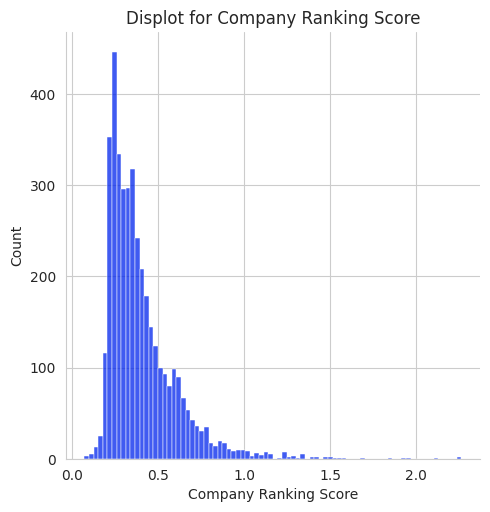

In [ ]:
import matplotlib.pyplot as plt

sns.set_palette("winter")
sns.set_style("whitegrid")

sns.displot(scores_pd["total"])

plt.xlabel("Company Ranking Score")
plt.ylabel("Count")

plt.title("Displot for Company Ranking Score")
plt.show()

In [ ]:
scores_pd.describe()

,merchant_abn,Customer_score,Revenue_score,Industry_score,Merchant_score,total
count,4.008000e+03,4008.000000,4008.000000,4008.000000,4008.000000,4008.000000
mean,5.443616e+10,0.067528,0.214977,0.906232,0.157030,1.345766
std,2.599297e+10,0.100194,0.101640,0.161390,0.172078,0.250831
min,1.002328e+10,0.000000,0.000000,0.490000,0.000000,0.719527
25%,3.160456e+10,0.010567,0.175095,0.866203,0.014078,1.246535
50%,5.429183e+10,0.016475,0.201143,0.999442,0.104066,1.334260
75%,7.662666e+10,0.081366,0.236844,1.000000,0.245583,1.458751
max,9.998791e+10,1.000000,1.000000,1.000000,1.000000,3.359829


In [ ]:
top100 = scores_pd.sort_values(by="total", ascending=False)["merchant_abn"][:100]

In [ ]:
merchants = sp.read.option("inferSchema", True).option("header", True).csv("../data/tables/merchants_tbl_processed.csv")
merchants.head()

Row(name='Felis Limited', merchant_abn=10023283211, Description='furniture home furnishing equipment shop manufacturer except appliance', Earnings_Class='e', BNPL_Fee=0.18)

In [ ]:
merged = scores.join(merchants, on="merchant_abn")
merged.show(1)

In [ ]:
final = merged.orderBy("total", ascending=False)
top10 = pd.DataFrame(final.head(10), columns=final.columns)
top10.head(2)

,merchant_abn,Customer_score,Revenue_score,Merchant_score,total,sector,name,Description,Earnings_Class,BNPL_Fee
0,51267358936,0.019788,0.002734,0.047601,0.070123,Personal_Services,Consectetuer Adipiscing Industries,antique shop sale repair restoration service,b,4.56
1,76866488151,0.035717,0.030676,0.009348,0.075740,Personal_Services,Euismod Urna Company,antique shop sale repair restoration service,b,4.08


#### Top 10 countries colored with sector

Text(0.5, 1.0, 'Top10 companies by scoring seen by sector')

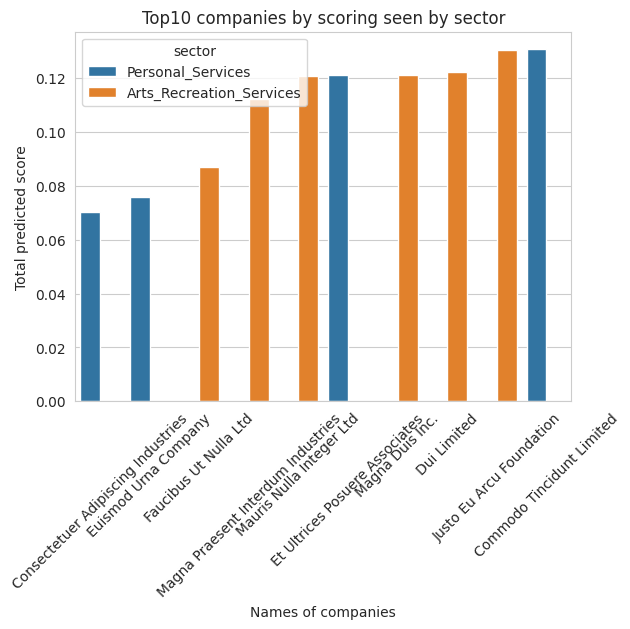

In [ ]:
sns.set_palette("tab10")

sns.barplot(x="name", y="total", data=top10, hue="sector")

plt.xticks(rotation=45)

plt.xlabel("Names of companies")
plt.ylabel("Total predicted score")

plt.title("Top10 companies by scoring seen by sector")

#### INSIGHTS FROM TOP 100

Profit generated by top 100 compared to the next 500 companies

In [ ]:
transactions = sp.read.option("inferSchema", True).parquet("../data/curated/transactions/")
transactions.show(1)

+-------+------------+------------+--------------+-----------+
|user_id|merchant_abn|dollar_value|order_datetime|   order_id|
+-------+------------+------------+--------------+-----------+
|  14935| 79417999332|      136.07|    2021-11-26|68719476736|
+-------+------------+------------+--------------+-----------+
only showing top 1 row



In [ ]:
revenue = transactions.groupBy("merchant_abn").sum("dollar_value").withColumnRenamed("sum(dollar_value)", "revenue")
revenue.show(1)

+------------+-----------------+
|merchant_abn|          revenue|
+------------+-----------------+
| 83412691377|498536.9797888398|
+------------+-----------------+
only showing top 1 row



In [ ]:
rev_merchant = revenue.join(merchants.drop("name", "Description"), on="merchant_abn")
rev_merchant.show(1)

+------------+-----------------+--------------+--------+
|merchant_abn|          revenue|Earnings_Class|BNPL_Fee|
+------------+-----------------+--------------+--------+
| 83412691377|498536.9797888398|             c|    2.94|
+------------+-----------------+--------------+--------+
only showing top 1 row



In [ ]:
from pyspark.sql.types import FloatType

rev_merchant = rev_merchant.withColumn("profit", (col('revenue') * col("BNPL_Fee") / 100).cast(FloatType()))
rev_merchant.show(1)

+------------+-----------------+--------------+--------+---------+
|merchant_abn|          revenue|Earnings_Class|BNPL_Fee|   profit|
+------------+-----------------+--------------+--------+---------+
| 83412691377|498536.9797888398|             c|    2.94|14656.987|
+------------+-----------------+--------------+--------+---------+
only showing top 1 row



In [ ]:
profit_table = rev_merchant.join(scores, on="merchant_abn")
profit_table.show(1)

In [ ]:
profit_table_sub = profit_table.select("merchant_abn", "profit" ,"total")
profit_table_sub.show(1)
profit_table_sub.orderBy("total", ascending=False).limit(100).groupBy().sum("profit").show()

+------------------+
|       sum(profit)|
+------------------+
|216291.50048065186|
+------------------+



In [ ]:
profit_table_sub.count()

4008

In [ ]:
profit_table_sub_pd = profit_table_sub.toPandas()
profit_table_sub_pd.iloc[100:600, ].sum()["profit"]

11851505.0

Text(0.5, 1.0, 'The profit of the given set of companies')

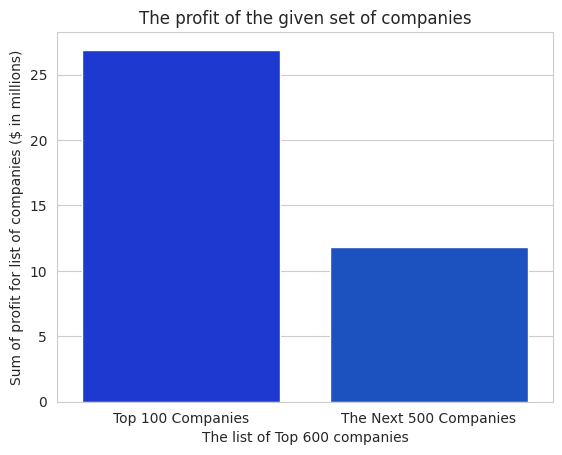

In [ ]:
sns.set_palette("winter")

sns.barplot(x = ["Top 100 Companies", "The Next 500 Companies"], y=[26.899846, 11.851505])

plt.xlabel("The list of Top 600 companies")
plt.ylabel("Sum of profit for list of companies ($ in millions)")

plt.title("The profit of the given set of companies")

In [ ]:
profit_table_sub.orderBy("total", ascending=False).limit(100)

+------------+---------+----------+
|merchant_abn|   profit|     total|
+------------+---------+----------+
| 83412691377|14656.987|1.48694578|
+------------+---------+----------+
only showing top 1 row



In [ ]:
c_fraud = sp.read.option("inferSchema", True).parquet("../data/curated/customer_fraud")
c_fraud = c_fraud.withColumn("order_datetime", col("order_datetime").cast(DateType()))
c_fraud.show(1)

+-------+--------------+-----------------+
|user_id|order_datetime|fraud_probability|
+-------+--------------+-----------------+
|   6228|    2021-12-19|         97.62981|
+-------+--------------+-----------------+
only showing top 1 row



In [ ]:
c_fraud = c_fraud.join(transactions, on=["user_id", "order_datetime"])
c_fraud.show()

+-------+--------------+-----------------+------------+------------+-----------+
|user_id|order_datetime|fraud_probability|merchant_abn|dollar_value|   order_id|
+-------+--------------+-----------------+------------+------------+-----------+
|     58|    2021-11-26|         9.241198| 43725628716|     2684.36|68719477029|
|     58|    2021-11-26|         9.241198| 45629217853|         0.2|68719477031|
|     58|    2021-11-26|         9.241198| 73499119023|        9.26|68719477033|
|     69|    2021-11-26|        15.645332| 30623214058|      111.91|68719477093|
|     69|    2021-11-26|        15.645332| 79417999332|        54.9|68719477095|
|     69|    2021-11-26|        15.645332| 18305506006|         5.2|68719477097|
|     69|    2021-11-26|        15.645332| 96244711717|       52.49|68719477099|
|     69|    2021-11-26|        15.645332| 34967436738|      4298.7|68719477101|
|     69|    2021-11-26|        15.645332| 16248082282|      361.55|68719477103|
|  15039|    2021-11-26|    

In [ ]:
m_fraud = c_fraud.groupBy("merchant_abn").avg("fraud_probability")
m_fraud.show()

In [ ]:
fraud_table = profit_table.join(m_fraud, on="merchant_abn").select("merchant_abn", "profit", "total", "sector", "avg(fraud_probability)")
fraud_table.show(4)

+------------+---------+----------+-----------------+----------------------+
|merchant_abn|   profit|     total|           sector|avg(fraud_probability)|
+------------+---------+----------+-----------------+----------------------+
| 83412691377|14656.987|1.48694578|Personal_Services|    14.404884085935706|
| 38700038932| 602364.3| 2.2550373|Personal_Services|     11.19901338719433|
| 35344855546|3934.3286|1.26370766|Personal_Services|    14.432141780853271|
| 15613631617|1900.6064|1.25646921|Personal_Services|     9.641129112243652|
+------------+---------+----------+-----------------+----------------------+
only showing top 4 rows



In [ ]:
fraud_table_pd = fraud_table.toPandas()
fraud_table_pd.head()

,merchant_abn,profit,total,sector,avg(fraud_probability)
0,83412691377,14656.987305,1.486946,Personal_Services,14.404884
1,38700038932,602364.312500,2.255037,Personal_Services,11.199013
2,35344855546,3934.328613,1.263708,Personal_Services,14.432142
3,15613631617,1900.606445,1.256469,Personal_Services,9.641129
4,19839532017,5630.710938,1.104964,Information_Media_Telecommunications,9.432743


In [ ]:
fraud_table_pd.iloc[:100,].mean()

/tmp/ipykernel_31069/3502639695.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  fraud_table_pd.iloc[:100,].mean()


merchant_abn              5.115336e+10
profit                    3.294384e+04
total                     1.309961e+00
avg(fraud_probability)    1.451704e+01
dtype: float64

In [ ]:
fraud_table_pd.iloc[100:600,].mean()

/tmp/ipykernel_31069/722460129.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  fraud_table_pd.iloc[100:600,].mean()


merchant_abn              5.442669e+10
profit                    3.336612e+04
total                     1.339912e+00
avg(fraud_probability)    1.462152e+01
dtype: float64

In [ ]:
sector_analysis = profit_table.select("merchant_abn", "total", "sector").orderBy("total", ascending=False)
sector_analysis.show(2)

+------------+----------+--------------------+
|merchant_abn|     total|              sector|
+------------+----------+--------------------+
| 24852446429|2.26287681|Administrative_Su...|
| 43186523025|2.23809834|Administrative_Su...|
+------------+----------+--------------------+
only showing top 2 rows



In [ ]:
sec_anal_pd = sector_analysis.limit(100).toPandas()
to_pie = sec_anal_pd["sector"].value_counts()
to_pie.index

Index(['Administrative_Support_Services', 'Personal_Services',
       'Information_Media_Telecommunications', 'Arts_Recreation_Services'],
      dtype='object')

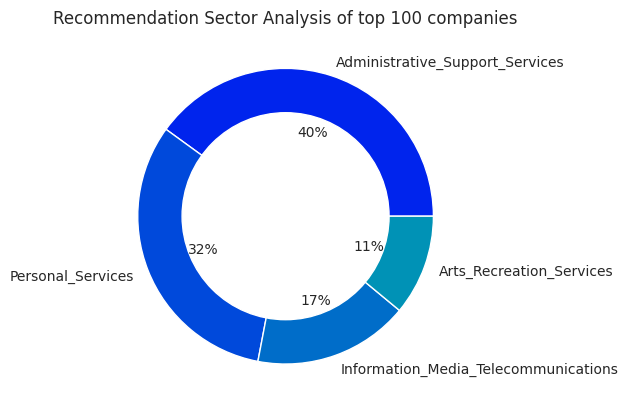

In [ ]:
plt.pie(to_pie.values, labels=to_pie.index, autopct='%1.0f%%', startangle=0)
my_circle = plt.Circle((0,0), 0.7, color="white")
p=plt.gcf()
plt.title("Recommendation Sector Analysis of top 100 companies")
p.gca().add_artist(my_circle)

plt.show()

In [ ]:
# EARNINGS CLASS RECOMMENDATION

e_class = sector_analysis.limit(100).join(merchants, on="merchant_abn") 
e_class.show(2)

+------------+----------+--------------------+--------------+--------------------+--------------+--------+
|merchant_abn|     total|              sector|          name|         Description|Earnings_Class|BNPL_Fee|
+------------+----------+--------------------+--------------+--------------------+--------------+--------+
| 10346855916|1.01090918|Administrative_Su...|Odio Institute|equipment tool fu...|             b|    3.57|
| 11439466003|0.99770108|   Personal_Services|Blandit At LLC|           shoe shop|             a|    5.71|
+------------+----------+--------------------+--------------+--------------------+--------------+--------+
only showing top 2 rows



In [ ]:
merchant_fraud = sp.read.option("inferSchema", True).option("header", True).csv("../data/tables/merchant_fraud_probability.csv")
merchant_fraud = merchant_fraud.withColumn("order_datetime", col("order_datetime").cast(DateType()))
merchant_fraud.show(1)

+------------+--------------+------------------+
|merchant_abn|order_datetime| fraud_probability|
+------------+--------------+------------------+
| 19492220327|    2021-11-28|44.403658647495355|
+------------+--------------+------------------+
only showing top 1 row



In [ ]:
fraud100 = profit_table.orderBy("total", ascending=False).limit(100).join(merchant_fraud, on="merchant_abn")
fraud100.count()

34

In [ ]:
fraud100_pd = fraud100.toPandas()
fraud100_pd.head()

,merchant_abn,revenue,Earnings_Class,BNPL_Fee,profit,Customer_score,Revenue_score,Merchant_score,total,sector,order_datetime,fraud_probability
0,21439773999,9.426656e+06,a,6.10,575026.00000,0.574197,0.981726,0.139616,1.695539,Information_Media_Telecommunications,2021-11-26,28.504479
1,94493496784,9.115636e+06,a,5.65,515033.40625,0.506634,0.955355,0.021901,1.483890,Personal_Services,2021-11-26,30.579032
2,48534649627,9.408958e+06,a,6.64,624754.81250,0.422008,1.000000,0.008034,1.430041,Personal_Services,2021-11-27,28.337370
3,48534649627,9.408958e+06,a,6.64,624754.81250,0.422008,1.000000,0.008034,1.430041,Personal_Services,2021-11-29,28.360522
4,48534649627,9.408958e+06,a,6.64,624754.81250,0.422008,1.000000,0.008034,1.430041,Personal_Services,2021-11-26,29.005907


#### Fraud for the top 100 merchants

Text(0.5, 1.0, 'Scores vs Fraud Probability')

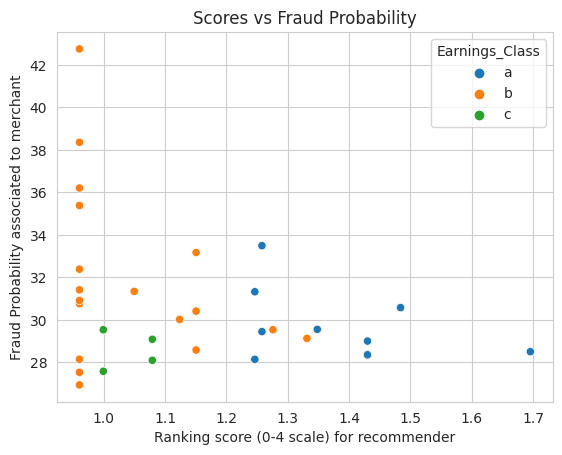

In [ ]:
sns.scatterplot(x="total", y="fraud_probability", hue="Earnings_Class", data=fraud100_pd)

plt.xlabel("Ranking score (0-4 scale) for recommender")
plt.ylabel("Fraud Probability associated to merchant")

plt.title("Scores vs Fraud Probability")

#### SECTOR DISTRIBUTIONS

In [ ]:
merchant_info = sp.read.parquet('../data/curated/full_dataset_Variation/')

In [ ]:
linkage = sp.read.csv('../data/curated/sector_lookup_table.csv', header=True)

In [ ]:
# pre process industry
merchant_info = merchant_info.select('merchant_abn', 'Description').distinct()

In [ ]:
merchant_info = merchant_info.join(linkage, on= merchant_info.Description == linkage.Description, how='inner')

In [ ]:
merchant_info = merchant_info.select('merchant_abn', 'sector').distinct()

In [ ]:
# Read all our tables 
customer_scaled = sp.read.parquet('../data/Normalised/customer_scaled/')
customer_scaled = customer_scaled.fillna(0.5)
industry_raw = sp.read.parquet('../data/Normalised/industry_scailed/')
industry_raw = industry_raw.fillna(0.5)
merchant_scaled = sp.read.parquet('../data/Normalised/merchant_scaled/')
merchant_scaled = merchant_scaled.fillna(0.5)
revenue_scaled = sp.read.parquet('../data/Normalised/revenue_scailed/')
revenue_scaled = revenue_scaled.fillna(0.5)

In [ ]:
# slip ups 
industry_scaled = merchant_info.join(industry_raw, on='sector').drop('sector')
revenue_scaled = revenue_scaled.select('merchant_abn', 'Revenue_Growth_Avg', 'Total_Revenue')

In [ ]:
from operator import add
from functools import reduce
# For each table we need to perform the following steps
def scroring_process(dataset, toggle=False):
    # first subtract 1 from each cell then square
    for col in dataset.columns[1:]:
        dataset = dataset.withColumn(col, F.pow((F.col(col) - 1),2))
    # sum the columns 
    if toggle != False:
        dataset.withColumn('Industry_score', F.col('Industry_score') * toggle)
    new_df = dataset.withColumn('total',F.round(reduce(add, [F.col(x) for x in dataset.columns[1:]]), 8))
    return new_df


In [ ]:
# Define our scaliong function
def feature_standardisation(dataset): 
    values = dataset.select(F.max('total').alias('high'), F.min('total').alias('low'))
    dataset = dataset.withColumn('total', F.round((F.col('total') - values.select('low').head()[0]) / (values.select('high').head()[0] - values.select('low').head()[0]), 9))
    return dataset.select('merchant_abn', 'total')

In [ ]:
# score industry, then add to merchants 
industry_scaled = scroring_process(industry_scaled)
industry_scaled = industry_scaled.select('merchant_abn','total')
industry_scaled = feature_standardisation(industry_scaled)
industry_scaled = industry_scaled.withColumnRenamed('total','Industry_score')
merchant_scaled = merchant_scaled.join(industry_scaled, on='merchant_abn', how='left')

In [ ]:
customer_scaled = scroring_process(customer_scaled)
merchant_scaled = scroring_process(merchant_scaled)
revenue_scaled = scroring_process(revenue_scaled)

In [ ]:
# rescale them 
customer_scaled = customer_scaled.select('merchant_abn','total')
customer_scaled = feature_standardisation(customer_scaled)
customer_scaled = customer_scaled.withColumnRenamed('total','Customer_score')
revenue_scaled = revenue_scaled.select('merchant_abn','total')
revenue_scaled = feature_standardisation(revenue_scaled)
revenue_scaled = revenue_scaled.withColumnRenamed('total','Revenue_score')
merchant_scaled = merchant_scaled.select('merchant_abn','total')
merchant_scaled = feature_standardisation(merchant_scaled)
merchant_scaled = merchant_scaled.withColumnRenamed('total','Merchant_score')

In [ ]:
# Finally join 
Full_scores = customer_scaled.join(revenue_scaled, on='merchant_abn', how='inner').join(merchant_scaled, on='merchant_abn', how='inner')

In [ ]:
# now scale and done 
#Industry_scale_factor = 1
Full_scores = scroring_process(Full_scores)

Full_scores = Full_scores.join(merchant_info.join(industry_raw, on='sector').select('merchant_abn', 'sector').distinct(), on='merchant_abn', how='left')
Full_scores.write.parquet('../data/Normalised/Final_scores_alt', mode='overwrite')
Full_scores.orderBy('total')

merchant_abn,Customer_score,Revenue_score,Merchant_score,total,sector
51267358936,0.01978842111457032,0.002734449080641...,0.04760055839997249,0.07012343,Personal_Services
76866488151,0.03571687576104992,0.030675506556620036,0.009347573870853911,0.07573996,Personal_Services
15704713883,0.011522631285990405,0.011707148679378087,0.06357232296702564,0.0868021,Arts_Recreation_S...
94110063346,0.007175589268322...,0.050007783720136804,0.055182001492982004,0.11236537,Arts_Recreation_S...
28880110118,0.013614814674121432,0.017838621391935216,0.08943800747101066,0.12089144,Arts_Recreation_S...
88299699256,0.010096594743766975,0.03807481384371458,0.07286396215489502,0.12103537,Personal_Services
80067991455,0.01041290875028291,0.04929437771425038,0.061451868555475866,0.12115916,Arts_Recreation_S...
68548907085,0.01057564910210063,0.05627265137615635,0.05531034781987344,0.12215865,Arts_Recreation_S...
99807059634,0.013676499533085477,0.0347891150307072,0.08185567448395024,0.13032129,Arts_Recreation_S...
38049816588,0.0191568015919776,0.03135851143055571,0.0801403285734116,0.13065564,Personal_Services


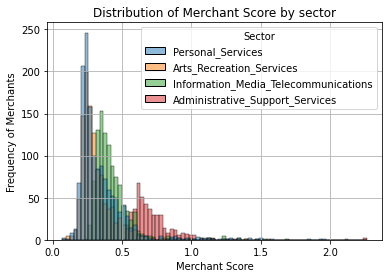

In [ ]:
Full_scores = Full_scores.withColumnRenamed('sector', 'Sector')
import seaborn as sns
import matplotlib.pyplot as plt
fig = sns.histplot(x='total', hue='Sector', data=Full_scores.toPandas()).set(title='Distribution of Merchant Score by Sector')
plt.xlabel('Merchant Score')
plt.ylabel('Frequency of Merchants')
plt.title('Distribution of Merchant Score by sector') # You can comment this line out if you don't need title
plt.grid()
plt.show(fig)

In [ ]:
pie_data = Full_scores.orderBy('total').limit(100).toPandas()

In [ ]:
pie_data.groupby('Sector').count()

,merchant_abn,Customer_score,Revenue_score,Merchant_score,total
Sector,,,,,
Arts_Recreation_Services,44,44,44,44,44
Personal_Services,56,56,56,56,56
